# Embedding Space visualisation

In [17]:
# locations
# data path for step 2
DIM = 128

root = "/home/shi/WorkSpace/projects/scMultiNet_Data/"
code_loc = "/home/shi/WorkSpace/projects/scMultiNet_workspace/"

# raw dataset saved by dill
raw_data_loc = root+"/Step_1_data/Dataset_cook/TrVal_dataset_PC_TGFb_Cook_GT_with_cellLine.pkl"

# scBERT with PEFT ckpt loc
scBERT_PEFT_ckpt = root+"/Step_1_data/Pretrained/scBERT_EMT_PEFT_Cook.ckpt"

# task root and processed embedding vectors from scMultiNet-categories 
task_root = root+"/Step_2_data/Cook/classification/" # root loc for data folder
train_root = task_root + "/train/"
val_root =task_root + "/val/"

save_root = root + "//Step_5_data/figures/"

save_root_data = root + "/Step_5_data/data/"
# ckpt for fusion model
scMultiNet_fusion_ckpt = task_root + "/ckpt/model_0.9019531292560845.ckpt"


import sys

sys.path.append(code_loc)

feature_locs = [
    "cls0.pkl",
    "cls1.pkl",
    "cls2.pkl",
    "cls3.pkl",
    "cls4.pkl",
]


In [2]:
# visualisation parameters
# 定义类别和颜色
label_order = ["0d", "8h", "1d", "3d", "7d"]
colors = ['#0c1b33', '#437c90', '#8b212c', '#f55141', '#ffa360']

# 创建标签到颜色的映射
label_color_map = {label: color for label, color in zip(label_order, colors)}

In [3]:
import scanpy as sc
# PCA plot function
def plot_pca(adata,label_order,save_folder,file_name):
    sc.settings.figdir = save_folder
    # 第 3 步：Scanpy 分析
    # 计算 PCA
    sc.tl.pca(adata, svd_solver='arpack')

    # 使用 PCA 计算邻居图
    sc.pp.neighbors(adata, use_rep='X_pca')

    # 第 4 步：结果分析和可视化
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors

    # 确保GT列的数据类型是category
    adata.obs['labels'] = adata.obs['labels'].astype('category')

    # 确保类别顺序
    adata.obs['labels'] = adata.obs['labels'].cat.reorder_categories(label_order)

    # 将颜色映射到GT类别并保存到adata.uns中
    adata.uns['labels_colors'] = colors
    # 在 PCA 嵌入上进行可视化
    sc.pl.scatter(adata, basis='pca', color=["labels"], title=['PCA'], save=file_name)

In [4]:
# phate plot function
def plot_phate(adata,label_order,save_folder,file_name):
    sc.settings.figdir = save_folder
    # 第 3 步：Scanpy 分析
    import phate
    # 使用 PHATE 计算嵌入
    phate_op = phate.PHATE()
    phate_emb = phate_op.fit_transform(adata.X)
    # 将 PHATE 嵌入结果存储到 AnnData 对象中
    adata.obsm['X_phate'] = phate_emb

    # 使用 PHATE 嵌入计算邻居图
    sc.pp.neighbors(adata, use_rep='X_phate')

    # 第 4 步：结果分析和可视化
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors

    # 第 4 步：结果分析和可视化
    # 转换颜色代码为十六进制格式

    # 在 PHATE 嵌入上进行 DPT 可视化
    #sc.pl.scatter(adata, basis='phate', color=["GT"], title=['GT'], palette=label_color_map)

    # 确保GT列的数据类型是category
    adata.obs['labels'] = adata.obs['labels'].astype('category')

    # 确保类别顺序
    adata.obs['labels'] = adata.obs['labels'].cat.reorder_categories(label_order)

    # 将颜色映射到GT类别并保存到adata.uns中
    adata.uns['labels_colors'] = colors

    # 使用sc.pl.scatter进行可视化，这次不需要手动传递palette参数
    
    sc.pl.scatter(adata, basis='phate', color='labels', title='Phate', save=file_name)

In [5]:
# umap plot function
def plot_umap(adata,label_order,save_folder,file_name):
    sc.settings.figdir = save_folder
    # 第 3 步：Scanpy 分析
    # 使用 UMAP 计算嵌入
    sc.pp.neighbors(adata, use_rep='X', n_neighbors=10)
    sc.tl.umap(adata)

    # 第 4 步：结果分析和可视化
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors

    # 确保GT列的数据类型是category
    adata.obs['labels'] = adata.obs['labels'].astype('category')

    # 确保类别顺序
    adata.obs['labels'] = adata.obs['labels'].cat.reorder_categories(label_order)

    # 将颜色映射到GT类别并保存到adata.uns中
    adata.uns['labels_colors'] = colors

    # 在 UMAP 嵌入上进行可视化
    sc.pl.umap(adata, color=["labels"], title=['UMAP'], save=file_name)

## Cook et al raw gene expression matrix

In [6]:
# read data
import sys
sys.path.append("/home/shi/WorkSpace/projects/scMultiNet_workspace")
import scLLM

# 数据集读取
import dill
# 用dill打开loc0的pkl 文件读取dataset
with open(raw_data_loc,"rb") as f:
    [dataset_1,_,_,label_dict] = dill.load(f)
# 输出数据集信息
print("trainset size: ",len(dataset_1))

print(label_dict)
# reverse label_dict
rev_label_dict = {v:k for k,v in label_dict.items()}
print(rev_label_dict)

vocab = "/home/shi/WorkSpace/projects/scLLM_workspace/vocab_16k.json"
# read vocab
import json
with open(vocab,"r") as f:
    gene_names = json.load(f)


trainset size:  5881
{'3d': 0, '7d': 1, '1d': 2, '8h': 3, '0d': 4}
{0: '3d', 1: '7d', 2: '1d', 3: '8h', 4: '0d'}


In [7]:
import scanpy as sc
# 第 1 步: 读取数据
exp_raw_data = dataset_1.data
labels = dataset_1.label
root_label_value = label_dict["0d"]
# 第 2 步：数据准备
adata = sc.AnnData(X=exp_raw_data)
adata.var_names = [name for name, _ in sorted(gene_names.items(), key=lambda x: x[1])]
adata.obs['labels'] = [rev_label_dict[label.item()] for label in labels] 

/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/umap/distances.py:108

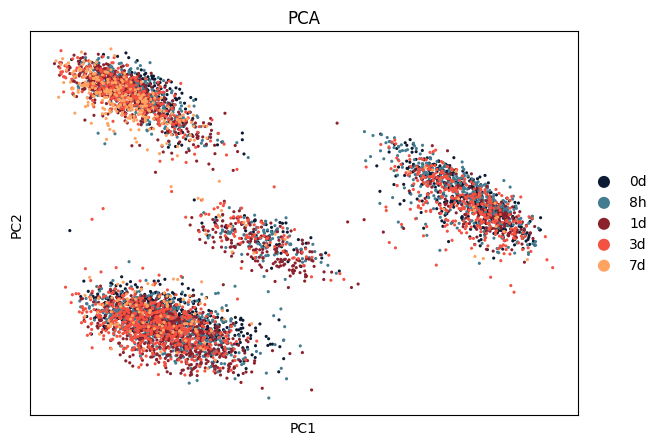

In [8]:
plot_pca(adata,label_order,save_root,"_raw_expression.pdf")

Calculating PHATE...
  Running PHATE on 5881 observations and 16906 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.56 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.35 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 5.97 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.60 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.75 seconds.
  Calculated landmark operator in 6.71 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 23.05 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.51 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.28 seconds.
Calculated PHATE in 38.51 seconds.


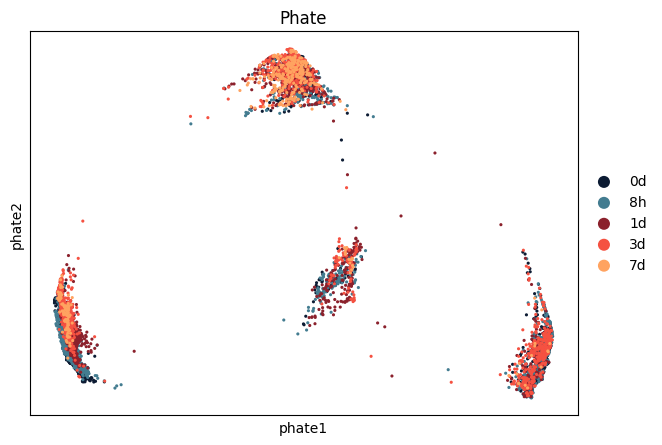

In [9]:
plot_phate(adata,label_order,save_root,"_raw_expression.pdf")

/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


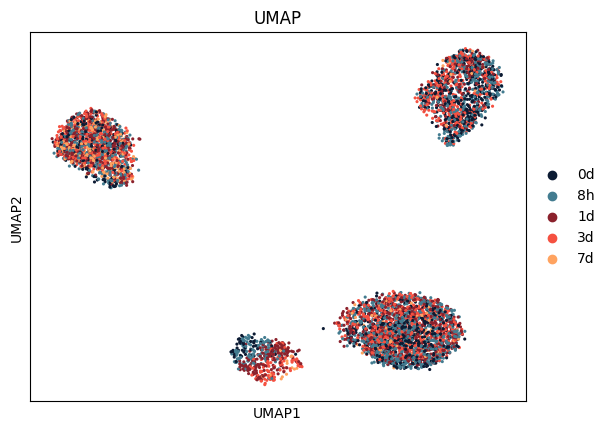

In [10]:
plot_umap(adata,label_order,save_root,"_raw_expression.pdf")

## scBERT raw model embedding space

In [11]:
import sys
sys.path.append(code_loc)


vocab_loc = code_loc+"/Experiment/support_data/vocab_16k.json"
vocab_params = code_loc+"/Experiment/support_data/gene2vec_16906_200.npy"
model_ckpt = root + "/pretrained/panglao_pretrain.pth"

In [12]:
# 数据集读取
import dill
# 用dill打开loc0的pkl 文件读取dataset
with open(raw_data_loc,"rb") as f:
    [trainset,valset,_,label_dict] = dill.load(f)
# 输出数据集信息
print("trainset size: ",len(trainset))
print("valset size: ",len(valset)) if valset is not None else print("no valset")
print(label_dict)

trainset size:  5881
valset size:  1471
{'3d': 0, '7d': 1, '1d': 2, '8h': 3, '0d': 4}


In [13]:

import torch
import numpy as np
from pathlib import Path
from scLLM.Predefine.scBERT_classification import model_para,trainer_para

#-----> project
trainer_para.project = "debug" # project name
trainer_para.entity= "shipan_work" # entity name
trainer_para.exp_name = trainer_para.exp_name + "EMT—infer" # experiment name
#-----> dataset
trainer_para.task_type = "classification" # "classification","regression"
trainer_para.class_nb = 5 # number of classes
trainer_para.batch_size =1 # batch size
#-----> model
trainer_para.pre_trained = model_ckpt#
trainer_para.ckpt_folder = str(Path(model_ckpt).parent)+"/" #

#-----> pytorch lightning paras
trainer_para.trainer_output_dir = str(Path(model_ckpt).parent)+"/" 
trainer_para.wandb_api_key = None


#-----> scBERT model paras
model_para.g2v_weight_loc = vocab_params#



from scLLM.Models.scBERT.pl import pl_scBERT
pl_model = pl_scBERT(trainer_paras=trainer_para,model_paras=model_para)

#--------> change the model to PEFT model
pl_model.model.load_state_dict(torch.load(trainer_para.pre_trained,map_location=torch.device('cpu'))["model_state_dict"],strict=True)

scLLM - INFO - init pytorch-lightning basic part...
scLLM - INFO - create loss instance...
scLLM - DEBUG - loss: <class 'torch.nn.modules.loss.CrossEntropyLoss'>
scLLM - INFO - init metrics factory...
scLLM - DEBUG - metrics_names: ['accuracy', 'f1_score', 'precision'] with paras: None
scLLM - INFO - init scBERT pytorch-lightning ...
scLLM - INFO - init scBERT model...
scLLM - DEBUG - model paras: scBERT_para(model_name='scBERT', num_tokens=7, max_seq_len=16907, dim=200, depth=6, heads=10, dim_head=64, local_attn_heads=0, local_window_size=256, causal=False, ff_mult=4, feature_redraw_interval=1000, reversible=False, ff_chunks=1, emb_dropout=0.0, ff_dropout=0.0, attn_dropout=0.0, generalized_attention=False, kernel_fn=ReLU(), use_scalenorm=False, use_rezero=False, cross_attend=False, no_projection=False, tie_embed=False, g2v_position_emb=True, g2v_weight_loc='/home/shi/WorkSpace/projects/scMultiNet_workspace//Experiment/support_data/gene2vec_16906_200.npy', auto_check_redraw=True, qkv_b

<All keys matched successfully>

In [14]:
from scipy.sparse import vstack
sparse_matrix1 = trainset.data
sparse_matrix2 = valset.data
# 垂直拼接
data = vstack([sparse_matrix1, sparse_matrix2])
infer_size = data.shape[0]
print(data.shape)
label = np.concatenate([trainset.label,valset.label])
print(label.shape)
infer_class = trainset.cls_nb#

(7352, 16906)
(7352, 1)


In [ ]:
idx = 0

feat_list = np.zeros([infer_size,16907])
label_list = np.zeros([infer_size,1])
from tqdm import tqdm
pl_model.model.eval()

pl_model.model.to("cuda")
import torch.nn.functional as F

with torch.no_grad():
    for idx in tqdm(range(infer_size)):
        #data part
        full_seq = data[idx].toarray()[0]
        full_seq[full_seq > (infer_class - 2)] = infer_class - 2
        full_seq = torch.from_numpy(full_seq).long()
        full_seq = torch.cat((full_seq, torch.tensor([0]))).to("cuda")
        full_seq = full_seq.unsqueeze(0)
        
        last_full_seq = full_seq
        #label part
        y = label[idx]
        
        # model part
        out=pl_model.model(full_seq,output_attentions = False)
        pred = out.detach().cpu().numpy()
        pred = np.mean(pred,axis=2).squeeze()

        #print(out)
        feat_list[idx,:] = pred
        label_list[idx,:] = y

In [18]:
import pickle

# 保存feat_list
#with open(save_root+"/scBERT_raw_Cook_feat_list.pkl","wb") as f:
    #pickle.dump([feat_list,label_list],f)
with open(save_root_data+"/scBERT_raw_Cook_feat_list.pkl","rb") as f:
    [feat_list,label_list] = pickle.load(f)
print(feat_list.shape, label_list.shape)

(7352, 16907) (7352, 1)


In [19]:
import scanpy as sc
# 第 1 步: 读取数据
exp_raw_data = feat_list
labels = label_list
root_label_value = label_dict["0d"]
# 第 2 步：数据准备
adata = sc.AnnData(X=exp_raw_data)
adata.obs['labels'] = [rev_label_dict[label.item()] for label in labels] 

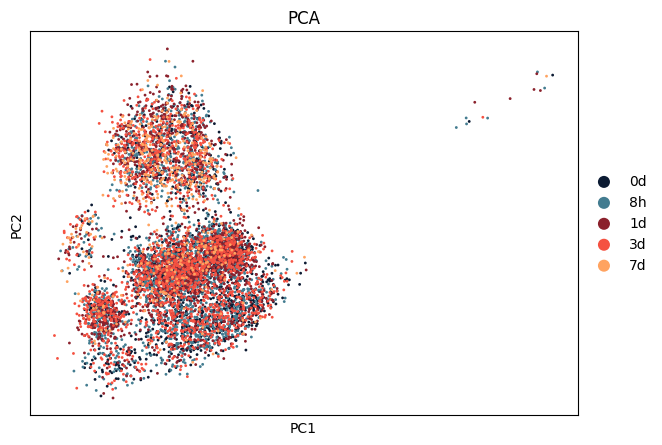

In [20]:
plot_pca(adata,label_order,save_root,"_scBERT_raw_bembedding.pdf")

Calculating PHATE...
  Running PHATE on 7352 observations and 16907 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 7.48 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.21 seconds.
    Calculating affinities...
    Calculated affinities in 0.38 seconds.
  Calculated graph and diffusion operator in 10.07 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.36 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.37 seconds.
  Calculated landmark operator in 6.10 seconds.
  Calculating optimal t...
    Automatically selected t = 13
  Calculated optimal t in 22.63 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.46 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.20 seconds.
Calculated PHATE in 41.46 seconds.


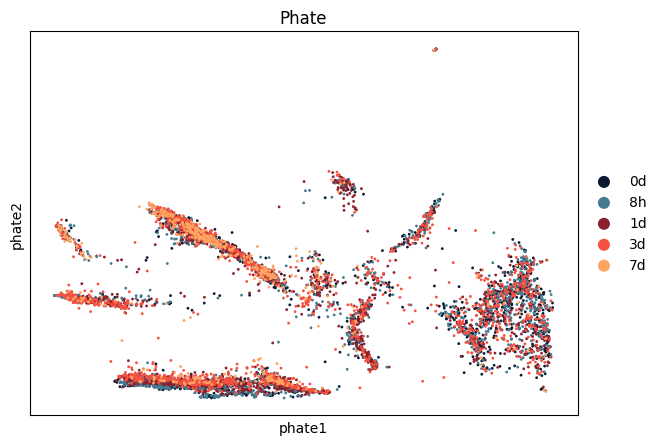

In [21]:
plot_phate(adata,label_order,save_root,"_scBERT_raw_bembedding.pdf")

/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


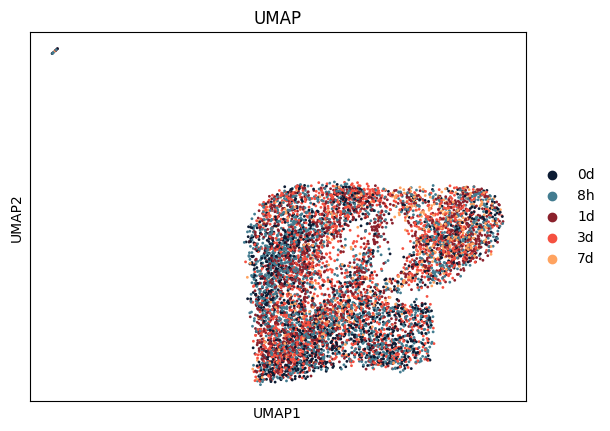

In [22]:
plot_umap(adata,label_order,save_root,"_scBERT_raw_bembedding.pdf")

## scBERT-PEFT model

In [23]:
import sys
sys.path.append(code_loc)


vocab_loc = code_loc+"/Experiment/support_data/vocab_16k.json"
vocab_params = code_loc+"/Experiment/support_data/gene2vec_16906_200.npy"
raw_model_ckpt = root + "/pretrained/panglao_pretrain.pth"
model_ckpt = root + "/pretrained/scBERT_PEFT/_epoch=09-accuracy_val=0.52.ckpt" 

In [24]:
# 数据集读取
import dill
# 用dill打开loc0的pkl 文件读取dataset
with open(raw_data_loc,"rb") as f:
    [trainset,valset,_,label_dict] = dill.load(f)
# 输出数据集信息
print("trainset size: ",len(trainset))
print("valset size: ",len(valset)) if valset is not None else print("no valset")
print(label_dict)

trainset size:  5881
valset size:  1471
{'3d': 0, '7d': 1, '1d': 2, '8h': 3, '0d': 4}


In [25]:
import torch
import numpy as np
from pathlib import Path
from scLLM.Predefine.scBERT_classification import model_para,trainer_para

#-----> project
trainer_para.project = "debug" # project name
trainer_para.entity= "shipan_work" # entity name
trainer_para.exp_name = trainer_para.exp_name + "EMT—infer" # experiment name
#-----> dataset
trainer_para.task_type = "classification" # "classification","regression"
trainer_para.class_nb = 5 # number of classes
trainer_para.batch_size =1 # batch size
#-----> model
trainer_para.pre_trained = model_ckpt#
trainer_para.ckpt_folder = str(Path(model_ckpt).parent)+"/" #

#-----> pytorch lightning paras
trainer_para.trainer_output_dir = str(Path(model_ckpt).parent)+"/" 
trainer_para.wandb_api_key = None


#-----> scBERT model paras
model_para.g2v_weight_loc = vocab_params#

#-----> peft paras
PEFT_name = "lora"
from scLLM.Modules.ops.lora import default_lora_para
lora_para = default_lora_para
lora_para.r = 1
lora_para.lora_alpha = 1
lora_para.enable_lora = True

from scLLM.Models.scBERT.pl import pl_scBERT
pl_model = pl_scBERT(trainer_paras=trainer_para,model_paras=model_para)

#--------> change the model to PEFT model
from scLLM.Models.PEFT import get_peft
peft = get_peft(pl_model,PEFT_name,lora_para)

# change output layer
from scLLM.Modules.layers.out_layer import scBERT_OutLayer

# change output layer
from scLLM.Modules.layers.out_layer import scBERT_OutLayer
peft.pl_model.model.to_out = scBERT_OutLayer(in_dim=model_para.max_seq_len,
                        dropout=0., 
                        h_dim=128, 
                        out_dim=trainer_para.class_nb,)

ckpt_params = torch.load(model_ckpt,map_location=torch.device('cpu'))
peft.pl_model.load_state_dict(ckpt_params['state_dict'])
peft.pl_model.model.to_out = None

scLLM - INFO - init pytorch-lightning basic part...
scLLM - INFO - create loss instance...
scLLM - DEBUG - loss: <class 'torch.nn.modules.loss.CrossEntropyLoss'>
scLLM - INFO - init metrics factory...
scLLM - DEBUG - metrics_names: ['accuracy', 'f1_score', 'precision'] with paras: None
scLLM - INFO - init scBERT pytorch-lightning ...
scLLM - INFO - init scBERT model...
scLLM - DEBUG - model paras: scBERT_para(model_name='scBERT', num_tokens=7, max_seq_len=16907, dim=200, depth=6, heads=10, dim_head=64, local_attn_heads=0, local_window_size=256, causal=False, ff_mult=4, feature_redraw_interval=1000, reversible=False, ff_chunks=1, emb_dropout=0.0, ff_dropout=0.0, attn_dropout=0.0, generalized_attention=False, kernel_fn=ReLU(), use_scalenorm=False, use_rezero=False, cross_attend=False, no_projection=False, tie_embed=False, g2v_position_emb=True, g2v_weight_loc='/home/shi/WorkSpace/projects/scMultiNet_workspace//Experiment/support_data/gene2vec_16906_200.npy', auto_check_redraw=True, qkv_b

In [26]:
from scipy.sparse import vstack
sparse_matrix1 = trainset.data
sparse_matrix2 = valset.data
# 垂直拼接
data = vstack([sparse_matrix1, sparse_matrix2])
infer_size = data.shape[0]
print(data.shape)
label = np.concatenate([trainset.label,valset.label])
print(label.shape)
infer_class = trainset.cls_nb#

(7352, 16906)
(7352, 1)


In [ ]:
idx = 0

feat_list = np.zeros([infer_size,16907])
label_list = np.zeros([infer_size,1])
from tqdm import tqdm
pl_model.model.eval()

pl_model.model.to("cuda")
import torch.nn.functional as F

with torch.no_grad():
    for idx in tqdm(range(infer_size)):
        #data part
        full_seq = data[idx].toarray()[0]
        full_seq[full_seq > (infer_class - 2)] = infer_class - 2
        full_seq = torch.from_numpy(full_seq).long()
        full_seq = torch.cat((full_seq, torch.tensor([0]))).to("cuda")
        full_seq = full_seq.unsqueeze(0)
        
        last_full_seq = full_seq
        #label part
        y = label[idx]
        
        # model part
        out=pl_model.model(full_seq,output_attentions = False,return_encodings=True)
        pred = out.detach().cpu().numpy()
        pred = np.mean(pred,axis=2).squeeze()

        #print(out)
        feat_list[idx,:] = pred
        label_list[idx,:] = y

In [28]:

# 保存feat_list
#with open(save_root_data+"/scBERT_PEFT_Cook_feat_list.pkl","wb") as f:
#    pickle.dump([feat_list,label_list],f)
with open(save_root_data+"/scBERT_PEFT_Cook_feat_list.pkl","rb") as f:
    [feat_list,label_list] = pickle.load(f)

print(feat_list.shape, label_list.shape)

(7352, 16907) (7352, 1)


In [29]:
import scanpy as sc
# 第 1 步: 读取数据
exp_raw_data = feat_list
labels = label_list
root_label_value = label_dict["0d"]
# 第 2 步：数据准备
adata = sc.AnnData(X=exp_raw_data)
adata.obs['labels'] = [rev_label_dict[label.item()] for label in labels] 

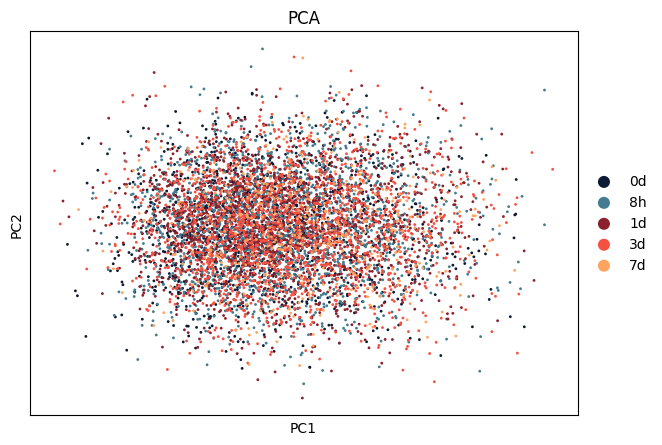

In [30]:
plot_pca(adata,label_order,save_root,"_scBERT_PEFT_bembedding.pdf")

Calculating PHATE...
  Running PHATE on 7352 observations and 16907 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 7.98 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.30 seconds.
    Calculating affinities...
    Calculated affinities in 2.19 seconds.
  Calculated graph and diffusion operator in 12.49 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.79 seconds.
    Calculating KMeans...
    Calculated KMeans in 6.72 seconds.
  Calculated landmark operator in 9.00 seconds.
  Calculating optimal t...
    Automatically selected t = 5
  Calculated optimal t in 25.58 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.30 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.29 seconds.
Calculated PHATE in 49.67 seconds.


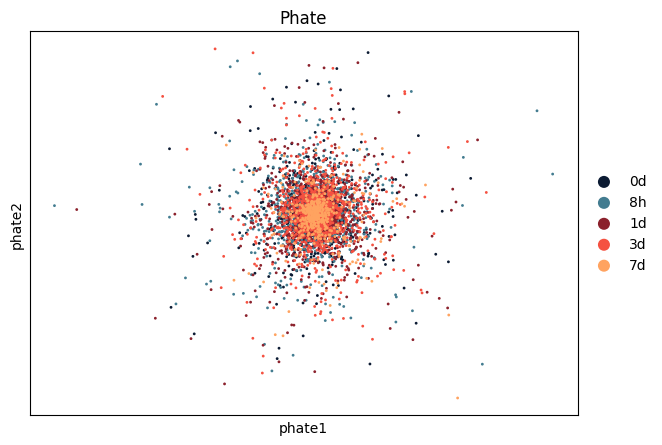

In [31]:
plot_phate(adata,label_order,save_root,"_scBERT_PEFT_bembedding.pdf")

/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


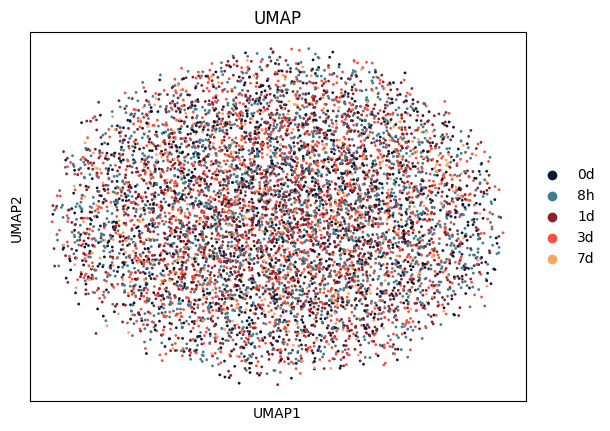

In [32]:
plot_umap(adata,label_order,save_root,"_scBERT_PEFT_bembedding.pdf")

## scMultiNet

In [33]:
# load model and calc features
import torch
import torch.nn.functional as F
import sys
DIM = 128


# 从文件夹中读取所有类的feature matrix
import pickle
import numpy as np


#-->train
train_feat_list = []
for i in range(len(feature_locs)):
    with open(train_root+feature_locs[i],"rb") as f:
        [feat,label] = pickle.load(f)
        train_feat_list.append(feat)
train_label = label
print(len(train_feat_list),train_feat_list[0].shape,train_label.shape)
# 合并feat_list中的feature matrix，[sample_nb,feat_dim] -> [sample_nb,feat_dim*5]
train_feat = np.concatenate(train_feat_list,axis=1) 
train_feat = torch.from_numpy(train_feat).float()
train_label = torch.from_numpy(train_label).long() 
# label from [sample_nb,1] -> [sample_nb,class_nb]
train_label = torch.zeros(train_label.shape[0],5).scatter_(1,train_label,1)


# get Dataset and DataLoader
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(train_feat,train_label)

trainloader = DataLoader(trainset,batch_size=DIM,shuffle=False)

5 (5881, 128) (5881, 1)


In [34]:
import torch.nn as nn
class FuseNet(nn.Module):
    def __init__(self,in_dim=128*5, dropout = 0., h_dim = 128, out_dim = 5, ):
        nn.Module.__init__(self,)

        self.fc1 = nn.Linear(in_features=in_dim, out_features=512, bias=True)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(in_features=512, out_features=h_dim, bias=True)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(in_features=h_dim, out_features=out_dim, bias=True)

    def forward(self, x, out_key:str = "all"):

        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        if out_key == "fc1":
            return x

        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        if out_key == "fc2":
            return x
        x = self.fc3(x)
        if out_key == "all":
            return x
        else:
            raise ValueError("out_key must be one of 'fc1', 'fc2', 'all'")


# get model
model = FuseNet(in_dim=DIM*5, dropout = 0., h_dim = DIM, out_dim = 5, )
# load model
model.load_state_dict(torch.load(scMultiNet_fusion_ckpt))



<All keys matched successfully>

In [35]:
# get features
model.eval()
feat_layer = "fc1"
all_feat = []
all_multi_emb = []
all_label = []
all_pred = []
with torch.no_grad():
    for data in trainloader:
        inputs,label = data
        feat = model(inputs,out_key=feat_layer)
        all_feat.append(feat)
        all_label.append(label)
        all_multi_emb.append(inputs)
        pred = model(inputs,out_key="all")
        prob = F.softmax(pred,dim=1)
        y_hat = torch.argmax(prob,dim=1)
        all_pred.append(y_hat)
embedding = torch.cat(all_feat,dim=0).detach().numpy()
labels = torch.cat(all_label,dim=0).detach().numpy()
preds = torch.cat(all_pred,dim=0).detach().numpy()
all_multi_emb = torch.cat(all_multi_emb,dim=0).detach().numpy()
print(embedding.shape,labels.shape,preds.shape)
labels = np.argmax(labels,axis=1)
print(labels)

(5881, 512) (5881, 5) (5881,)
[0 0 2 ... 2 1 0]


In [36]:
import scanpy as sc
# 第 1 步: 读取数据
root_label_value = label_dict["0d"]
# 第 2 步：数据准备
adata = sc.AnnData(X=all_multi_emb)
adata.obs['labels'] = [rev_label_dict[label.item()] for label in labels]


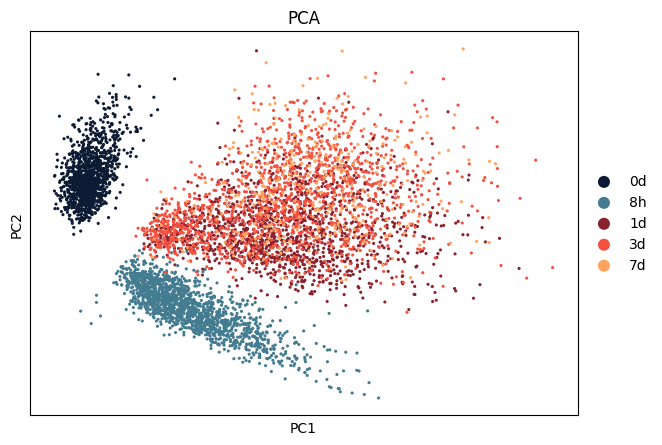

In [37]:
plot_pca(adata,label_order,save_root,"_scMultiNet_bembedding.pdf")

/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


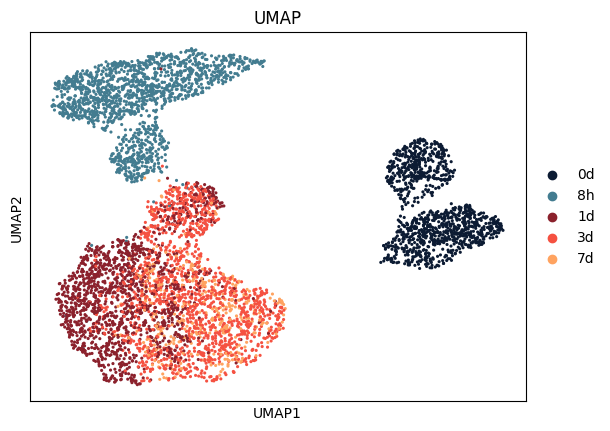

In [38]:
plot_umap(adata,label_order,save_root,"_scMultiNet_bembedding.pdf")

Calculating PHATE...
  Running PHATE on 5881 observations and 640 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.67 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.72 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 2.40 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.13 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.69 seconds.
  Calculated landmark operator in 7.15 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 24.68 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.57 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.36 seconds.
Calculated PHATE in 37.18 seconds.


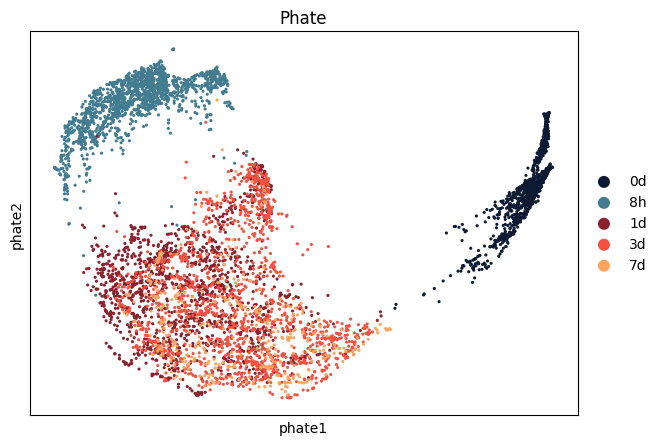

In [39]:
plot_phate(adata,label_order,save_root,"_scMultiNet_bembedding.pdf")

## EMT-MultiNet

In [40]:
import scanpy as sc
# 第 1 步: 读取数据
root_label_value = label_dict["0d"]
# 第 2 步：数据准备
adata = sc.AnnData(X=embedding)
adata.obs['labels'] = [rev_label_dict[label.item()] for label in labels]


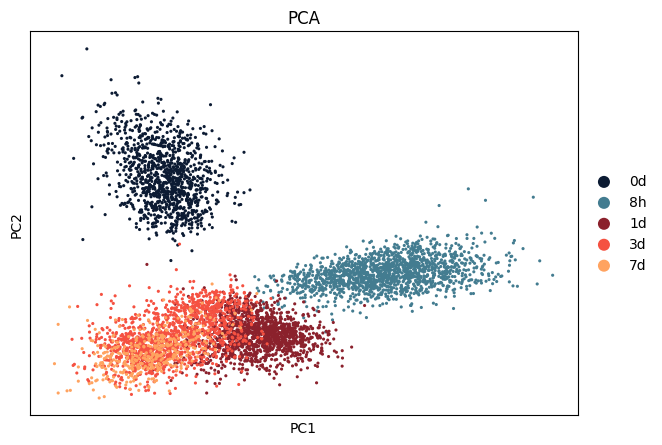

In [41]:
plot_pca(adata,label_order,save_root,"_EMT_MultiNet_embedding.pdf")

Calculating PHATE...
  Running PHATE on 5881 observations and 512 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.89 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.77 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 2.68 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.99 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.28 seconds.
  Calculated landmark operator in 5.62 seconds.
  Calculating optimal t...
    Automatically selected t = 31
  Calculated optimal t in 24.23 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.69 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.25 seconds.
Calculated PHATE in 35.47 seconds.


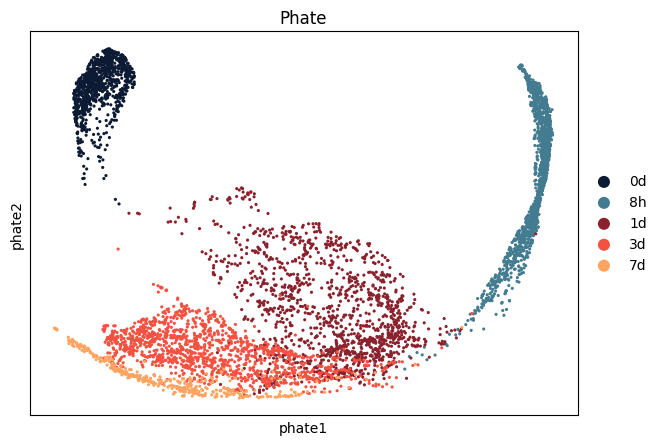

In [42]:
plot_phate(adata,label_order,save_root,"_EMT_MultiNet_embedding.pdf")

/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


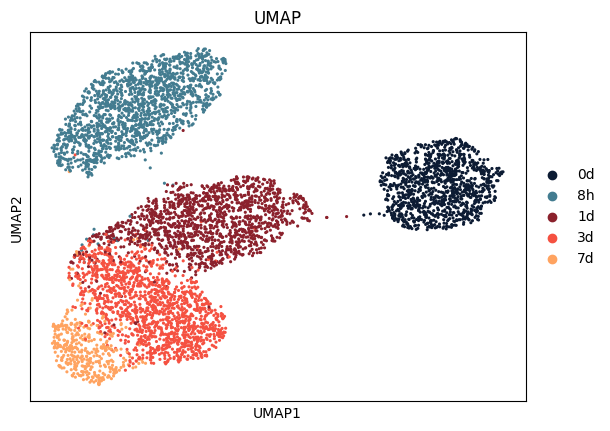

In [43]:
plot_umap(adata,label_order,save_root,"_EMT_MultiNet_embedding.pdf")